<a href="https://colab.research.google.com/github/ksasi/EVA/blob/master/Project25/Assignment25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DCGAN** - Trained with 100x100 Car Images

In [1]:
# Obtain GPU detals

!nvidia-smi

Wed Nov 27 05:05:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Obtain CUDA version and other details

!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
# Obtain Python version information

!python -V

Python 3.6.8


In [4]:
# Install Tensorflow 2.0 GPU version

!pip install tensorflow-gpu

In [0]:
# Install imageio to generate GIFs
!pip install -q imageio

In [6]:
# Import all the necessary libraties i.e. numpy, PIL, os, tensorflow
# Print tensorflow and tf.keras versions

import numpy as np
import glob
import imageio
import os
import PIL
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import time

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
from IPython import display

print(tf.version.VERSION)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [0]:
# Enable eager execution in tensorflow. This is to ensure we use custom training loop with Gradient tape

#tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()

In [8]:
# Attach google drive to colab notebook

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Path for the data set

data_root = "/content/drive/My Drive/GAN Dataset"

In [0]:
# list_ds stores the list of files i.e. jpeg files of car images

list_ds = tf.data.Dataset.list_files(data_root+'/'+'*')

In [11]:
# List sample images

for f in list_ds.take(5):
  print(f.numpy())


b'/content/drive/My Drive/GAN Dataset/img_630.jpg'
b'/content/drive/My Drive/GAN Dataset/img_208.jpg'
b'/content/drive/My Drive/GAN Dataset/img_758.jpg'
b'/content/drive/My Drive/GAN Dataset/img_269.jpg'
b'/content/drive/My Drive/GAN Dataset/img_004.jpg'


In [0]:
# Image dimensions are set to 96x96. The decode_img function returns a image tensor with float values. Source : https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 

IMG_WIDTH = 96
IMG_HEIGHT = 96

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
# Function that returns an image tensor by reading the image from the given file_path argument. Source : https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 

def process_path(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [0]:
# Setup AUTOTUNE and use map to process mutliple images. Source : https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
Image_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
# Print the shape of the image

for image in Image_ds.take(1):
  print("Image shape: ", image.numpy().shape)

Image shape:  (96, 96, 3)


In [0]:
# Function to generate a dataset using shuffle, batch and prefect operations from tf.records, tf.data. Source : https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  #ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
# Set batch size and then preprate a dataset for training

BATCH_SIZE = 128

train_ds = prepare_for_training(Image_ds)

In [0]:
# Function that defines a generator model. This is basically a DEConvolution network.  Modified from Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(6*6*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((6, 6, 256)))
    assert model.output_shape == (None, 6, 6, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 6, 6, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())



    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())



    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


 
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 96, 96, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 96, 96, 3)

    return model

In [19]:
# Create a generator model and check the model summary for shape information.

model = make_generator_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9216)              921600    
_________________________________________________________________
batch_normalization (BatchNo (None, 9216)              36864     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 9216)              0         
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 6, 6, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 6, 128)         0

In [0]:
# Function that defines a discriminator model. This is basically a Convolutional Neural Network (CNN), which classifies fake vs real i.e. binary classification. Modified from Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[96, 96, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [21]:
# Create a discriminator model and check the model summary for shape information.

model = make_discriminator_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        4864      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 48, 48, 128)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 128)      

(1, 100)
(96, 96, 3)
tf.Tensor(
[[[ 4.83729536e-07  7.15664555e-06  5.92430297e-06]
  [-5.83159954e-06 -6.18524791e-06  1.32900414e-05]
  [ 1.86014313e-06  1.72790715e-05 -8.25035568e-06]
  ...
  [ 2.88180399e-05  4.29240117e-06  7.39784737e-05]
  [ 3.09703137e-05 -3.08369454e-05  3.75597920e-05]
  [ 5.99229406e-06  2.71978861e-05  3.64512671e-05]]

 [[ 1.40289776e-05  9.96157360e-06  5.16888690e-07]
  [ 4.84099428e-06  2.32059392e-05  4.03398190e-05]
  [ 2.58119398e-05  1.02056601e-05  6.41412862e-06]
  ...
  [-4.53742905e-05  2.28038971e-05  1.00916062e-04]
  [ 6.34039097e-05 -2.36057622e-05 -1.10594710e-05]
  [ 2.36277556e-05 -2.52434256e-06  1.64454086e-05]]

 [[ 3.99650526e-06  3.79180165e-06 -9.66004336e-06]
  [ 1.63578879e-05  2.08047186e-05 -1.00027446e-05]
  [-1.97995214e-05 -1.77957668e-06 -1.53516339e-07]
  ...
  [-1.87479764e-05 -2.20173824e-05  4.47648090e-05]
  [-9.40306018e-06 -1.43134548e-05 -1.62672541e-06]
  [-5.77034098e-06 -4.48665342e-05  3.74710944e-05]]

 ...

 [

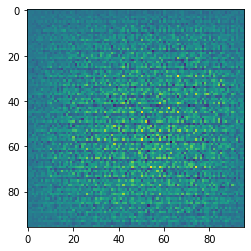

In [22]:
# Pass random noise as input to the generator and visualize the output from the generator. Adopted from Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

import matplotlib.cm as cm
generator = make_generator_model()

noise = tf.random.normal([1, 100])
print(noise.shape)
generated_image = generator(noise, training=False)
print(generated_image[0, :, :, :].shape)
print(generated_image[0, :, :, :])
img = tf.image.convert_image_dtype(generated_image[0, :, :, :], tf.uint8)
print(img)
plt.imshow(generated_image[0, :, :, 0])

In [23]:
# Print the output from the discriminator after passing the generated output from the previous step. Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[8.396871e-07]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss. Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Function to define discriminator loss. Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
# Function to define generator loss . Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# Define optimizer for generator and descriminator.

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 2

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Define check points.

checkpoint_dir = '/content/drive/My Drive/models'
checkpoint_prefix = os.path.join(checkpoint_dir, "DCGANckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# Define training step function . Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [0]:
# Define function for training . Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go for every 50 epochs
    if (epoch + 1) % 50 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
# Function to generate and save images. Modified from Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8), dpi = 200)

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      img = tf.image.convert_image_dtype(predictions[i, :, :, :], tf.uint8)
      #img = tf.io.encode_jpeg(img)
      #display_img = plt.imread(img)
      plt.imshow(img, cmap = None )
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.jpg'.format(epoch))
  plt.show()

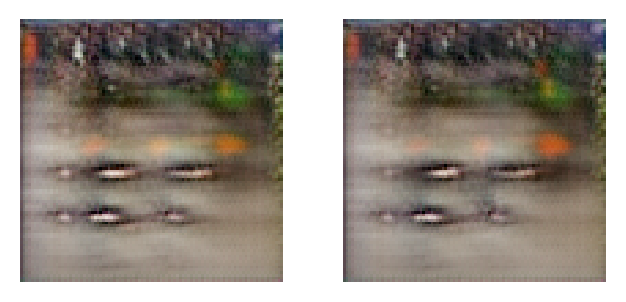

In [0]:
# Train for 1000 epochs (epoch 1 to epoch 1000)

train(train_ds, EPOCHS)

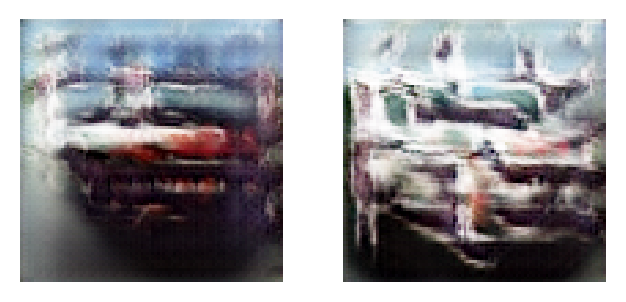

In [0]:
# Train for next 1000 epochs (epoch 1001 to epoch 2000)

train(train_ds, EPOCHS)

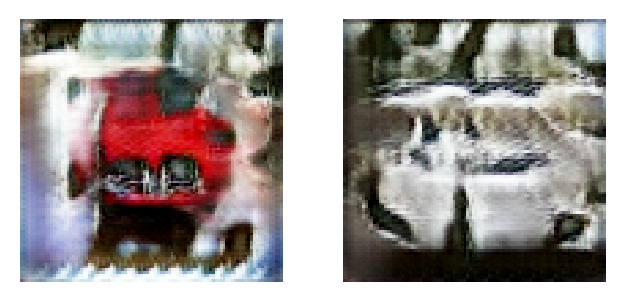

In [0]:
# Train for next 2000 epochs (epoch 2001 to epoch 3000)

train(train_ds, EPOCHS)

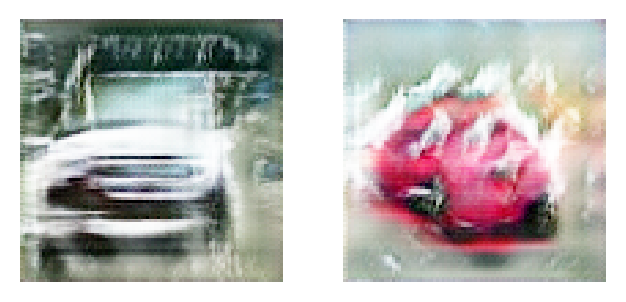

Time for epoch 600 is 7.03314471244812 sec
Time for epoch 601 is 5.177178144454956 sec
Time for epoch 602 is 5.563092470169067 sec
Time for epoch 603 is 5.557692766189575 sec
Time for epoch 604 is 5.5605223178863525 sec
Time for epoch 605 is 5.559485912322998 sec
Time for epoch 606 is 5.554863929748535 sec
Time for epoch 607 is 5.559101343154907 sec
Time for epoch 608 is 5.563067436218262 sec
Time for epoch 609 is 5.5620574951171875 sec
Time for epoch 610 is 5.558041334152222 sec
Time for epoch 611 is 5.561517238616943 sec
Time for epoch 612 is 5.560159683227539 sec
Time for epoch 613 is 5.560508489608765 sec
Time for epoch 614 is 5.558320760726929 sec
Time for epoch 615 is 6.490429401397705 sec
Time for epoch 616 is 5.180923700332642 sec
Time for epoch 617 is 5.557845592498779 sec
Time for epoch 618 is 5.559033393859863 sec
Time for epoch 619 is 5.5609612464904785 sec
Time for epoch 620 is 5.561546087265015 sec
Time for epoch 621 is 5.56238579750061 sec
Time for epoch 622 is 5.5600385

In [0]:
# Train for next 641 epochs (epoch 3001 to epoch 3642)

train(train_ds, EPOCHS)

In [0]:
# Restore the checkpoint as the training was terminated due to network issues and colab restart

status = checkpoint.restore(tf.train.latest_checkpoint('/content/drive/My Drive/models/'))

In [53]:
status.assert_existing_objects_matched()

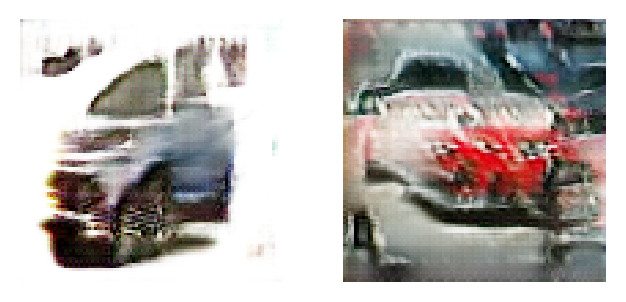

In [56]:
# Train for next 360 epochs (epoch 3642 to epoch 4002)

train(train_ds, 360)

## Generate Image by generator network

In [0]:
# Restore the final checkpoint

status = checkpoint.restore(tf.train.latest_checkpoint('/content/drive/My Drive/models/'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


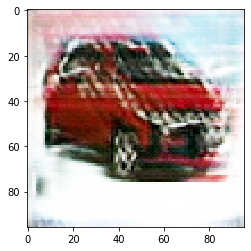

In [37]:
# Generate image from generator by passing uniform random noise

import matplotlib.cm as cm

noise = tf.random.normal([400, 100])
generated_image = generator(noise, training=False)
img = tf.image.convert_image_dtype(generated_image[0, :, :, :], tf.uint8)
plt.imshow(generated_image[0, :, :, :])

### **Observations :**


*   Generated images are blurry and not perfect
*   Training is carried out for **4000 epochs**
*   Mode collapse is not verified



### ToDo :

*   **Implement Inception Score (IS)** and **Fréchet Inception Distance (FID)** metrics
*   Check for **mode collapse** and implement techniques such as **Minibatch Discrimination**, **Wasserstein GANs**, **Experience Replay etc**.. for mitigation



### References & Attributions :


*   https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

*   https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 
*   https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
*   https://medium.com/@utk.is.here/training-a-conditional-dc-gan-on-cifar-10-fce88395d610
*   https://medium.com/@jonathan_hui/gan-how-to-measure-gan-performance-64b988c47732
*   https://developers.google.com/machine-learning/gan
*   https://github.com/eriklindernoren/Keras-GAN



#### Disclaimer: The contents of this notebook are used for educational purposes i.e. for learning and research.